In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd


In [1]:
def ReLU(x):
    if x > 0:
        return x
    return 0

In [2]:
def softmax(Z):
    return np.exp(Z) / np.sum(np.exp(Z))

In [ ]:
class MultiClassLogisticRegression(nn.Module):
    def __init__(self,n_features,n_classes ,learning_rate=0.01, n_iters=1000,device="cuda"):
        """
            Z = XW + b
            where:
            - X: input matrix (m x n)
            - W: weights matrix (n x K)
            - b: bias vector (1 x K)

            also:
            - m: number of observations
            - n: number of features
            - K: number of classes 
        """
        self.lr = learning_rate
        self.epochs = n_iters
        self.W1 = torch.rand((n_features,128),requires_grad=False,device=device)
        self.b1 = torch.rand((1,128), requires_grad=False,device=device)
        self.W2 = torch.rand((128,n_classes), requires_grad=False,device=device)
        self.b2 = torch.rand((1,n_classes), requires_grad=False,device=device)
        self.to(device)

    def ReLU(self,x:torch.Tensor) -> torch.Tensor:
        if x > 0:
            return x
        return 0
    
    def softmax(self,Z: torch.Tensor) -> torch.Tensor:
        return np.exp(Z) / np.sum(np.exp(Z))
    
    def forward(self,X:torch.Tensor):
        """
            Calculations:
                Z1 = X * W1 + b1
                H1 = max(0,Z1)
                Z2 = H1 * W2 + b2
                Pi = e^(Z2) / SUM(e^(Z2))
        """

        Z1 = X @ self.W1 + self.b1
        h1 = self.ReLU(Z1)
        Z2 = h1 @ self.W2 + self.b2
        P = self.softmax(Z2)
        return -np.log(P) # Cross Entropy Loss
    
    def backward(self,X:torch.Tensor,P,Y):
        """
            Example:
                L - loss/error
                We want to calculate dL/dW12 ( How change in W1 will impact on L)
                dL/dW12 = dZ1/dW12 * dH1/dZ1 * dZ2/dH1 * dPi/dZ2 * dL/dPi
                Remember the equations from the forward method
                dL/dW12 = X1 * (derivative of Relu) * (W2)
        """
        m = X.shape[0] # nr_observations
        # dL/dZ2 = P - Y 
        dZ2 = P - Y
        
        # 





        


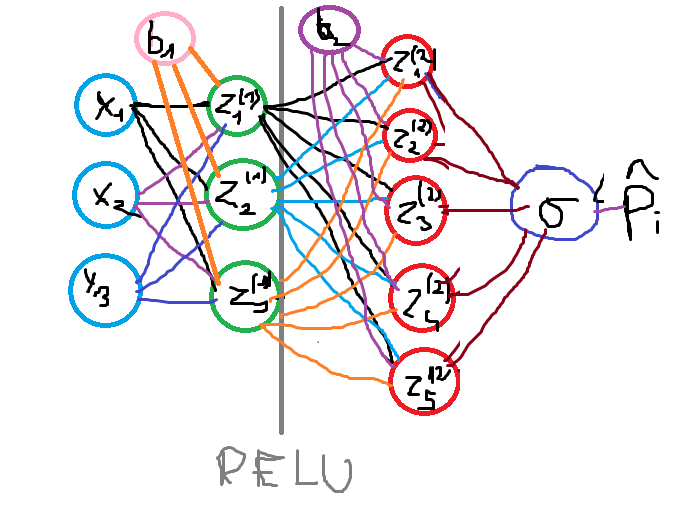